In [1]:
from bs4 import BeautifulSoup
from flow_wmd.documents import Document
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import re

%load_ext autoreload
%autoreload 2

## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [2]:
soc = pd.read_csv("soc.csv",low_memory=False)
soc["discipline"] = "soc"
econ = pd.read_csv("econ.csv",low_memory=False)
econ["discipline"] = "econ"

scopus = pd.concat([soc,econ])

stopword_list=stopwords.words('english')

scopus.drop([i for i in scopus.columns if "Unnamed" in i],axis=1,inplace=True)
scopus.reset_index(inplace=True,drop=True)

scopus.head()

,Authors,Year,Source title,Abstract,discipline
0,Uzzi B.,1996,American Sociological Review,"In this paper, I attempt to advance the concep...",soc
1,"Inglehart R., Baker W.E.",2000,American Sociological Review,Modernization theorists from Karl Marx to Dani...,soc
2,Burt R.S.,2004,American Journal of Sociology,This article outlines the mechanism by which b...,soc
3,"Meyer J.W., Boli J., Thomas G.M., Ramirez F.O.",1997,American Journal of Sociology,The authors analyze the nation-state as a worl...,soc
4,"Emirbayer M., Mische A.",1998,American Journal of Sociology,This article aims (1) to analytically disaggre...,soc


### 1.2 Initialize cleanup functions 

Functions to remove noisy formatting, lemmatizing and removing stopwords.

In [4]:
# Custom preprocessing functions
# Partly self-authored, partly from https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = re.sub('<br / ><br / >', ' ', text)
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z\s]'
    text=re.sub(pattern,'',text)
    return text

#Lemmatizing the text
def simple_lemmatizer(text):
    lemmatizer=WordNetLemmatizer() 
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

#removing the stopwords
def remove_stopwords(text, stopword_list, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token.lower() for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### 1.3 Remove special formatting and stopwords

Remove stopwords before denoising, lemmatizing and removing special characters.

In [5]:
%time 

tokenizer=ToktokTokenizer()
scopus['Abstract_clean']= [remove_stopwords(r, stopword_list) for r in scopus['Abstract']]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


Denoise, remove special characters, lemmatize.

In [6]:
%time

scopus['Abstract_clean']=scopus['Abstract_clean'].apply(denoise_text)
scopus['Abstract_clean']=scopus['Abstract_clean'].apply(remove_special_characters)
scopus['Abstract_clean']=scopus['Abstract_clean'].apply(simple_lemmatizer)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


Remove stopwords again, after other preprocessing.

In [7]:
%time 

scopus['Abstract_clean']= [remove_stopwords(r, stopword_list) for r in scopus['Abstract_clean']]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


Data _before_ preprocessing.

In [8]:
scopus['Abstract'][0]

"In this paper, I attempt to advance the concept of embeddedness beyond the level of a programmatic statement by developing a formulation that specifies how embeddedness and network structure affect economic action. On the basis of existing theory and original ethnographies of 23 apparel firms, I develop a systematic scheme that more fully demarcates the unique features, functions, and sources of embeddedness. From this scheme, I derive a set of refutable implications and test their plausibility, using another data set on the network ties of all better dress apparel firms in the New York apparel economy. Results reveal that embeddedness is an exchange system with unique opportunities relative to markets and that firms organized in networks have higher survival chances than do firms which maintain arm's-length market relationships. The positive effect of embeddedness reaches a threshold, however, after which point the positive effect reverses itself."

Data _after_ preprocessing.

In [9]:
scopus['Abstract_clean'][0]

'paper attempt advance concept embeddedness beyond level programmatic statement developing formulation specifies embeddedness network structure affect economic action basis existing theory original ethnography apparel firm develop systematic scheme fully demarcates unique feature function source embeddedness scheme derive set refutable implication test plausibility using another data set network tie better dress apparel firm new york apparel economy result reveal embeddedness exchange system unique opportunity relative market firm organized network higher survival chance firm maintain arm slength market relationship positive effect embeddedness reach threshold however point positive effect revers'

### 1.4 Separate pos and neg reviews

In [10]:
soc = scopus[scopus.discipline == "soc"].reset_index(drop=True)
econ = scopus[scopus.discipline == "econ"].reset_index(drop=True)

In [11]:
soc = soc.Abstract_clean.tolist()
econ = econ.Abstract_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [20]:
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return tokens

soc_tok = list(map(tokenize, soc))
econ_tok = list(map(tokenize, econ))

In [21]:
soc_sample = [" ".join(doc) for doc in soc_tok]
econ_sample = [" ".join(doc) for doc in econ_tok]

### 2.2 Load pretrained Google News W2V model

In [22]:
def read_1w_corpus(name, sep="\t"):
    for line in open(name):
        yield line.split(sep)

print("Loading GoogleNews Vectors")
%time model = KeyedVectors.load_word2vec_format('/Users/jack/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)

Loading GoogleNews Vectors
CPU times: user 53.6 s, sys: 3.42 s, total: 57.1 s
Wall time: 58 s


### 2.3 Load corpus and remove OOV words

In [23]:
corpus = soc_sample + econ_sample

%time vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tokenize, norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 54 µs, sys: 182 µs, total: 236 µs
Wall time: 249 µs


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 926 ms, sys: 1.44 s, total: 2.36 s
Wall time: 5.58 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l1', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x1a230e7560>, use_idf=False,
                vocabulary=None)

In [24]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 31.2 ms, sys: 58.1 ms, total: 89.2 ms
Wall time: 91 ms


In [25]:
len(oov)

3692

In [26]:
#removing the oov words
def remove_oov(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in oov]
    #filtered_tokens = filter(lambda token: token not in oov, tokens)
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

%time soc_sample = list(map(remove_oov, soc_sample))
%time econ_sample = list(map(remove_oov, econ_sample))

CPU times: user 7.73 s, sys: 99.8 ms, total: 7.83 s
Wall time: 7.97 s
CPU times: user 3.28 s, sys: 35.1 ms, total: 3.31 s
Wall time: 3.36 s


In [27]:
soc_sample[0]

'paper attempt advance concept embeddedness beyond level programmatic statement developing formulation specifies embeddedness network structure affect economic action basis existing theory original ethnography apparel firm develop systematic scheme fully demarcates unique feature function source embeddedness scheme derive set refutable implication test plausibility using another data set network tie better dress apparel firm new york apparel economy result reveal embeddedness exchange system unique opportunity relative market firm organized network higher survival chance firm maintain arm market relationship positive effect embeddedness reach threshold however point positive effect revers'

In [28]:
corpus = soc_sample + econ_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 23 µs, sys: 13 µs, total: 36 µs
Wall time: 38.9 µs
CPU times: user 548 ms, sys: 21.2 ms, total: 570 ms
Wall time: 656 ms


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l1', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x1a230e7560>, use_idf=True,
                vocabulary=None)

Bag-of-words vectorizer.

In [29]:
%time
soc_nbow = vectorizer.transform(soc_sample)
econ_nbow = vectorizer.transform(econ_sample)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [30]:
soc_tok = list(map(tokenize, soc_sample))
econ_tok =  list(map(tokenize, econ_sample))

In [31]:
soc_tok[0][:20]

['paper',
 'attempt',
 'advance',
 'concept',
 'embeddedness',
 'beyond',
 'level',
 'programmatic',
 'statement',
 'developing',
 'formulation',
 'specifies',
 'embeddedness',
 'network',
 'structure',
 'affect',
 'economic',
 'action',
 'basis',
 'existing']

In [32]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 17.6 ms, sys: 650 µs, total: 18.2 ms
Wall time: 18.5 ms


In [33]:
len(oov_)

0

In [34]:
len(corpus)

2829

### 2.4 Get features and embeddings

In [58]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [59]:
E = np.vstack([model.word_vec(word) for word in vectorizer.get_feature_names()])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  """Entry point for launching an IPython kernel.


### 2.5 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [60]:
%time 

soc_docs, econ_docs = [], []

for idx, doc in enumerate(soc_tok):
    soc_docs.append(Document(doc, soc_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(econ_tok):
    econ_docs.append(Document(doc, econ_nbow[idx], word2idx, E))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 14.1 µs


In [61]:
soc_docs[0].nbow

array([[0., 0., 0., ..., 0., 0., 0.]])

In [62]:
soc_docs[0].weights_sum

0.9999999999999998

In [63]:
soc_docs[0].idxs[:10]

[4480, 4227, 3460, 260, 10629, 2692, 3848, 777, 8844, 141]

In [64]:
soc_docs[0].vecs[:1][0][:10]

array([ 0.12792969, -0.10839844, -0.13476562,  0.07568359, -0.25585938,
       -0.12402344,  0.13183594, -0.11767578, -0.08154297, -0.1015625 ],
      dtype=float32)

### 2.6 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [65]:
%time lc_rwmd = LC_RWMD(soc_docs, econ_docs,soc_nbow,econ_nbow,E)
%time lc_rwmd.get_D()
#%time lc_rwmd.get_L(1)
#%time lc_rwmd.get_rwmd()

CPU times: user 19 µs, sys: 200 µs, total: 219 µs
Wall time: 995 µs
CPU times: user 11min 45s, sys: 1min 41s, total: 13min 26s
Wall time: 3min 24s


### 2.7 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [66]:
from flow_wmd.gale_shapeley import Matcher

matcher = Matcher(lc_rwmd.D)
engaged = matcher.matchmaker()
matcher.check()
pairs = engaged

Let's look at the output of Gale-Shapeley:

In [67]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))


take(10, pairs.items())

[(1009, 148),
 (323, 510),
 (1643, 563),
 (1348, 100),
 (786, 1000),
 (1247, 202),
 (134, 1002),
 (19, 196),
 (675, 1004),
 (1669, 356)]

### 2.8 Pairwise WMD

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [68]:
from flow_wmd.models import WMDPairs

wmd_pairs = WMDPairs(soc_docs,econ_docs,pairs,E,idx2word)
%time wmd_pairwise = wmd_pairs.get_distances()

Calculated distances between 0 documents.
Calculated distances between 100 documents.
Calculated distances between 200 documents.
Calculated distances between 300 documents.
Calculated distances between 400 documents.
Calculated distances between 500 documents.
Calculated distances between 600 documents.
Calculated distances between 700 documents.
Calculated distances between 800 documents.
Calculated distances between 900 documents.
Calculated distances between 1000 documents.
Calculated distances between 1100 documents.
CPU times: user 1min 28s, sys: 1.65 s, total: 1min 29s
Wall time: 23.6 s


The return value is a matrix of distances between the document pairs.

In [69]:
wmd_pairwise

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [70]:
wmd_pairs_flow = WMDPairs(soc_docs,econ_docs,pairs,E,idx2word)
%time wmd_pairwise_flow = wmd_pairs_flow.get_distances(return_flow = True)

Calculated distances between 0 documents.
Calculated distances between 100 documents.
Calculated distances between 200 documents.
Calculated distances between 300 documents.
Calculated distances between 400 documents.
Calculated distances between 500 documents.
Calculated distances between 600 documents.
Calculated distances between 700 documents.
Calculated distances between 800 documents.
Calculated distances between 900 documents.
Calculated distances between 1000 documents.
Calculated distances between 1100 documents.
CPU times: user 1min 32s, sys: 1.14 s, total: 1min 33s
Wall time: 23.9 s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [71]:
wmd_pairwise_flow[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [72]:
take(10, wmd_pairwise_flow[1].items())

[('deprived', 0),
 ('disaggregates', 0.062299999999999994),
 ('tit', 0.06724),
 ('neutralize', 0.10158),
 ('properly', 0.10774),
 ('bill', 0.27364),
 ('larceny', 0),
 ('mulatto', 0.24312999999999999),
 ('refresh', 0.09245),
 ('randomness', 0.18383)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [73]:
take(10, wmd_pairwise_flow[2].items())

[('needy', 0.10522999999999999),
 ('properly', 0.14555),
 ('bill', 0.37583999999999995),
 ('labile', 0.11868000000000001),
 ('randomness', 0.061380000000000004),
 ('motivate', 0.10601000000000001),
 ('monte', 0.20939),
 ('hunting', 0.11146),
 ('initiate', 0.23603000000000002),
 ('schooling', 2.13311)]

### 2.9 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [74]:
{k: v for k, v in sorted(wmd_pairwise_flow[1].items(), key=lambda item: item[1], reverse=True)[:30]}

{'social': 17.552079999999993,
 'woman': 12.597589999999997,
 'author': 10.976540000000005,
 'inequality': 10.68216,
 'network': 9.804319999999999,
 'effect': 9.714220000000001,
 'article': 9.640240000000002,
 'analysis': 8.398250000000003,
 'gender': 8.362820000000003,
 'status': 8.228179999999998,
 'relationship': 8.034370000000001,
 'data': 7.790869999999999,
 'study': 7.78603,
 'theory': 7.683050000000004,
 'economic': 7.498829999999997,
 'black': 7.461530000000001,
 'research': 7.283319999999998,
 'state': 7.230560000000003,
 'organization': 7.128590000000001,
 'family': 7.086600000000001,
 'survey': 7.0046500000000025,
 'segregation': 6.992670000000001,
 'political': 6.964210000000001,
 'chicago': 6.962130000000001,
 'child': 6.79948,
 'racial': 6.75736,
 'structure': 6.698240000000004,
 'men': 6.6356600000000014,
 'white': 6.4816999999999965,
 'labor': 6.344799999999999}

Next, let's see what added most distance when moving from the negative to the positive reviews.

In [79]:


vals = {k: v for k, v in sorted(wmd_pairwise_flow[2].items(), key=lambda item: item[1], reverse=True)}.values()

v = pd.DataFrame(vals)
v["cumsum"] = v[0].cumsum()
v['cum_perc'] = 100*v['cumsum']/v[0].sum()
#v.loc[640,"cum_perc"]
v["cumcount"] = [(i+1) / len(v) for i in range(len(v))]
v.head()


,0,cumsum,cum_perc,cumcount
0,17.26953,17.26953,0.511908,0.000147
1,14.38263,31.65216,0.938241,0.000294
2,13.08137,44.73353,1.326003,0.000440
3,12.97264,57.70617,1.710541,0.000587
4,11.87137,69.57754,2.062435,0.000734


In [94]:
len(v)

6811

In [95]:
v.index[6500]/len(v)

0.9543385699603583

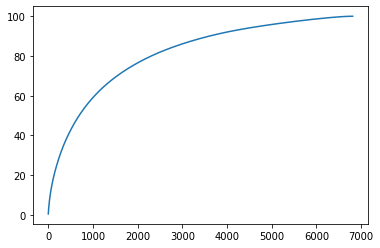

In [83]:
import matplotlib.pyplot as plt

plt.plot(v.index,v["cum_perc"])

## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [49]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 2min 17s, sys: 1.92 s, total: 2min 18s
Wall time: 54.3 s


In [50]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 2min 22s, sys: 1.9 s, total: 2min 24s
Wall time: 55.2 s


In [51]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [52]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}

49.97848431809601

In [227]:
len(v)

9881